In [2]:
import dill
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import json
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt

In [3]:
def pre_filter(df3):
    # оставляет только "разрешенные" колонки
    cols_to_proon = []
    for col in df3.columns:
        if 'device' in col:
            continue
        elif 'geo'in col:
            continue
        elif 'utm' in col:
            continue
        elif 'event_action' in col:
            continue
        else:
            cols_to_proon.append(col)
    df3 = df3.drop(cols_to_proon, axis=1)
    return df3

In [4]:
def event_action(df3):
    print('event_action start')
    target_action = ['sub_car_claim_click', 
                 'sub_car_claim_submit_click',
                 'sub_open_dialog_click', 
                 'sub_custom_question_submit_click', 
                 'sub_call_number_click', 
                 'sub_callback_submit_click', 
                 'sub_submit_success', 
                 'sub_car_request_submit_click'
                ]

    df3['event_action'] = df3['event_action'].apply(lambda x: 1 if x in target_action else 0)
    
    print( 'event_action end')
    print('-')      
    #print('-')      
    #print('-') 
    
    return df3

In [5]:
def sample_df3(df3, total_rows =  200000, neg_percent = 50, pos_percent = 50):
    print( 'sample_df3 start')
    df3_pos = df3[df3['event_action'] == 1].sample(int(total_rows / 100 * pos_percent))
    df3_neg = df3[df3['event_action'] == 0].sample(int(total_rows / 100 * neg_percent))
    df3_pos = df3_pos.reset_index()
    df3_neg = df3_neg.reset_index()
    df3_pos = df3_pos.drop('index', axis=1)
    df3_neg = df3_neg.drop('index', axis=1)
    df3 = pd.concat([df3_pos, df3_neg])
    
    print( 'sample_df3 end')
    print('-')      
    #print('-')      
    #print('-') 
    
    return df3

df = pd.read_csv('data/ga_hits.csv')

df2 = pd.read_csv('data/ga_sessions.csv')

df3 = pd.merge(df, df2, on='session_id')

df3 = event_action(df3)

In [6]:
def ad_campaign(df3):
    print( 'ad_campaign start')
    try:
        with open('data/utm_c_frec_dict2.json', 'r') as f:
            utm_c_frec_dict = json.load(f)
    except FileNotFoundError:
        print("oh.., looks like its the first time you run it - lil' bit longer then, m8. pls hold:)")

        utm_c_frec_dict = {}
        counter = 1
        for pos in df3.utm_campaign.unique():
            if len(df3[(df3.utm_campaign == pos) & (df3.event_action == 1)]) == 0:
                utm_c_frec_dict[str(pos)] = 0
            else:
                utm_c_frec_dict[str(pos)] = round(len(df3[(df3.utm_campaign == pos) & (df3.event_action == 1)]) / len(df3[df3.utm_campaign == pos]), 5)

            #print(counter)
            counter = counter  + 1
        with open('data/utm_c_frec_dict2.json', 'w') as f: 
            json.dump(utm_c_frec_dict, f)

    finally:
        df3['camp_succ_rate'] = df3.utm_campaign.apply(lambda x: utm_c_frec_dict[str(x)])
    
    #print(utm_c_frec_dict)
    print( 'ad_campaign end')
    print('-')      
    #print('-')      
    #print('-') 
    
    return df3

In [7]:
def ad_campaign_v_2(df3):
    import json
    print( 'ad_campaign v2 start')
    
    
    
    try:
        with open('data/utm_c_frec_dict3.json', 'r') as f:
            utm_c_frec_dict = json.load(f)
    except FileNotFoundError:
        print("oh.., looks like its the first time you run it - lil' bit longer then, m8. pls hold:)")
        df5 = df3[['utm_campaign', 'event_action']]
        succ_camps = df5[df5.event_action == 1].utm_campaign.value_counts(dropna=False)
        all_camps = df5.utm_campaign.value_counts(dropna=False)

        utm_c_frec_dict = {}
        
        for pos in all_camps.keys():
            if pos in succ_camps.keys():
                utm_c_frec_dict[str(pos)] = round(succ_camps[pos] / all_camps[pos], 5)
            else:
                utm_c_frec_dict[str(pos)] = 0
        
        
        with open('data/utm_c_frec_dict3.json', 'w') as f: 
            json.dump(utm_c_frec_dict, f)

    finally:
        df3['camp_succ_rate'] = df3.utm_campaign.apply(lambda x: utm_c_frec_dict[str(x)])
    
    #print(utm_c_frec_dict)
    print( 'ad_campaign v2 end')
    print('-')      
    #print('-')      
    #print('-') 
    
    return df3

In [8]:
def day_of_week(df3):
    print( 'day_of_week start')
    import pandas as pd
    df3['new_date'] = pd.to_datetime(df3['visit_date'])
    df3['day_of_week'] = df3.new_date.dt.dayofweek
    
    df3 = df3.drop('new_date', axis=1)
    print('day_of_week end')
    print('-')      
    #print('-')      
    #print('-') 
    
    return df3

In [9]:
def empties(df3):
    print( 'empties end')
    import pandas as pd
    df3.loc[df3.utm_source.isna() == True, 'utm_source'] = 'other'
    df3.loc[df3.utm_adcontent.isna() == True, 'utm_adcontent'] = 'Other'
    df3.loc[df3.device_brand.isna() == True, 'device_brand'] = 'other'
    
    print( 'empties end')
    print('-')      
    #print('-')      
    #print('-')  
    
    return df3

In [10]:
def resolution_func(df3):
    print('resolution_func start')
    import pandas as pd
    #resolution
    bounds = []
    
    try:
        with open('data/resolution_bounds.txt', 'r') as file:
            lines = file.readlines()
            for line in lines:
                values = line.strip().split(', ')
                bounds.append((values[0], int(values[1]), int(values[2])))
        
    except FileNotFoundError:
        df3['resolution'] = df3.device_screen_resolution.apply(lambda x:eval(x.replace('x','*')))
        for device in df3.device_category.unique():
            q25 = df3[df3.device_category == device].resolution.quantile(0.25)
            q75 = df3[df3.device_category == device].resolution.quantile(0.75)
            iqr = q75 - q25
            bounds.append((device, q25 - 1.5 * iqr, q75 + 1.5 * iqr))

        with open('data/resolution_bounds.txt', 'w') as file:
            for device in bounds:
                line = f"{device[0]}, {device[1]}, {device[2]}\n"
                file.write(line)
        df3 = df3.drop('resolution', axis=1)

    finally:
        
        test_list = list(df3.device_screen_resolution)
        test_list2 = list(df3.device_category)

        for i in range(len(test_list)):
            test_list[i] = eval(test_list[i].replace('x','*'))

        tst_l = list(zip(test_list2, test_list))

        resolution = []

        for i in range(len(tst_l)):
            if tst_l[i][0] == bounds[0][0]:
                resolution.append(bounds[0][0]+'_high' if tst_l[i][1] >= bounds[0][2] * 0.7 else (bounds[0][0]+'_medium' if bounds[0][2] * 0.7 > tst_l[i][1] >= bounds[0][2] * 0.1 else bounds[0][0]+'_low'))
            elif tst_l[i][0] == bounds[1][0]:
                resolution.append(bounds[1][0]+'_high' if tst_l[i][1] >= bounds[1][2] * 0.7 else (bounds[1][0]+'_medium' if bounds[1][2] * 0.7 > tst_l[i][1] >= bounds[1][2] * 0.1 else bounds[1][0]+'_low'))
            elif tst_l[i][0] == bounds[2][0]:
                resolution.append(bounds[2][0]+'_high' if tst_l[i][1] >= bounds[2][2] * 0.7 else (bounds[2][0]+'_medium' if bounds[2][2] * 0.7 > tst_l[i][1] >= bounds[2][2] * 0.1 else bounds[2][0]+'_low'))

        df3['device_screen_resolution_engeneered'] = resolution
        #df3['device_screen_resolution'] = resolution
        
    
    print('resolution_func end')
    print('-')      
    #print('-')      
    #print('-') 
    
    
    return df3
    

In [11]:
def resolution_func_v_2(df3):
    import pandas as pd
    print('resolution_func v2 start')
    #resolution
    bounds = []
    df3['device_screen_resolution'] = df3.device_screen_resolution.apply(lambda x:eval(x.replace('x','*')))

    
    print('resolution_func v2 end')
    print('-')      
    #print('-')      
    #print('-') 
    
    
    return df3
    

In [12]:
def country(df3, trsh = 0.001):
    import pandas as pd
    print('country start')
    #geo_country
    country_list = list(df3.geo_country.unique())
    for i in range(len(country_list)):
        country_list[i] = ( len(df3[df3.geo_country == country_list[i]]), country_list[i])
    country_list = sorted(country_list, reverse=True)

#    trsh = 0.0005
    df3_len = len(df3) 
    for item in country_list:
        if item[0] / df3_len >= trsh:
            continue
        else:
            df3.loc[df3.geo_country == item[1], 'geo_country'] = 'some_unimportant_country'
    
    print( 'country end')
    print('-')      
    #print('-')      
    #print('-') 
    
    return df3

In [13]:
def country_v_2(df3):
    import pandas as pd
    print('country v2  start')
    #geo_country
    counter = 0
    country_list_new = dict()
    
    
    try:
        with open('data/country_list_new.txt', 'r') as f:
            for line in f:
                # remove newline character and parentheses
                line = line.rstrip('\n').replace("%", '')
                tuple_elements = line.split('*')
                my_tuple = (tuple_elements[0], eval(tuple_elements[1]))
                country_list_new[my_tuple[0]] = my_tuple[1]


    except FileNotFoundError:
        print("oh.., looks like its the first time you run it - lil' bit longer then, m8. pls hold:)")
        
        succ_total = len(df3[df3.event_action == 1])
        country_list_success = df3[df3.event_action == 1].geo_country.value_counts().sort_values(ascending=False)
        country_list_new = []
        for country in country_list_success.keys():
            country_list_new.append(f'{country}*{str(round(country_list_success[country] / succ_total, 4))}%')
            counter += 1
            if counter == 23:
                break

        with open('data/country_list_new.txt', 'w') as f:
            for t in country_list_new:
                f.write(str(t) +'\n')
                
        country_list_new = dict()        
        with open('data/country_list_new.txt', 'r') as f:
            for line in f:
                # remove newline character and parentheses
                line = line.rstrip('\n').replace("%", '')
                tuple_elements = line.split('*')
                my_tuple = (tuple_elements[0], eval(tuple_elements[1]))
                country_list_new[my_tuple[0]] = my_tuple[1]                


    finally:
        df3['geo_country_succ_perc'] = df3['geo_country'].apply(lambda x: country_list_new[x] if x in country_list_new else 0.0001)
        
    

    #print(sum(df4.isnull().sum().values))
    #print(df4.isnull().sum())
    print('country v2 end')    
    print('-')      
    #print('-')      
    #print('-')     
    
    return df3

In [14]:
def country_v_3(df3, trsh=0.001):
    import pandas as pd
    # При первом запуске:
        # 1) создает список .value_counts по странам
        # Первый запуск рекоммендуется производить на полном датасете
        # 2) Записывает список в файл
        # 3)Оставляет только страны, колечество появлений которых составляет больше 0.001 от длины полного датасета
    # При последующих запусках берет готовый файл со значениями, далее п.3

    # print('country_v_3 start')
    country_list = []
    df3_len = len(df3)

    try:
        with open('data/country_list1.txt', 'r') as f:
            for line in f:
                line = line.rstrip('\n').replace('(', '').replace(')', '').replace("'", '')
                tuple_elements = [int(e.strip()) if e.strip().isdigit() else e.strip() for e in line.split(',')]
                my_tuple = tuple(tuple_elements)
                country_list.append(my_tuple)

    except FileNotFoundError:
        # print("oh.., looks like its the first time you run it - lil' bit longer then, m8. pls hold:)")

        country_list = list(zip(df3.geo_country.value_counts().values, df3.geo_country.value_counts().keys()))
        country_list = sorted(country_list, reverse=True)

        with open('data/country_list1.txt', 'w') as f:
            for t in country_list:
                f.write(str(t) + '\n')

    finally:
        country_list_valid = []

        for item in country_list:
            if item[0] / 15000000 >= trsh:
                country_list_valid.append(item[1])

        df3.loc[(~df3['geo_country'].isin(country_list_valid)), 'geo_country'] = 'some_unimportant_country'

    return df3



In [15]:
def city(df3, trsh = 0.001):
    import pandas as pd
    print('city start')
    #geo_city
    city_list = []
    df3_len = len(df3)
    try:
        with open('data/city_list1.txt', 'r') as f:
            for line in f:
                # remove newline character and parentheses
                line = line.rstrip('\n').replace('(', '').replace(')', '').replace("'", '')
                # split on comma and convert each element to correct type
                tuple_elements = [int(e.strip()) if e.strip().isdigit() else e.strip() for e in line.split(',')]
                # create tuple and add to list
                my_tuple = tuple(tuple_elements)
                city_list.append(my_tuple)


    except FileNotFoundError:
        print("oh.., looks like its the first time you run it - lil' bit longer then, m8. pls hold:)")

        city_list = list(zip(df3.geo_city.value_counts().values, df3.geo_city.value_counts().keys() ))
        city_list = sorted(city_list, reverse=True)

        with open('data/city_list1.txt', 'w') as f:
            for t in city_list:
                f.write(str(t) +'\n')



    finally:
#        trsh = 0.0005
        city_list_valid = []
        
        for item in city_list:
            #print(item[1], ' - ', round(item[0] / df3_len, 4),'%' )
            if round(item[0] / 15000000, 4) >= trsh:   #df3_len, 4) >= trsh:
                city_list_valid.append(item[1])
                #print('trsh == 2000 - ', item[0], item[1], round(item[0] / df3_len, 4) >= trsh, ' - appended')

        df3.loc[(~df3['geo_city'].isin(city_list_valid)), 'geo_city'] = 'some_unimportant_city'
    
    

    #print(sum(df4.isnull().sum().values))
    #print(df4.isnull().sum())
    print('city end')    
    print('-')      
    #print('-')      
    #print('-')      
    
    return df3

In [16]:
def city_v_2(df3):
    import pandas as pd
    print('city v2  start')
    #geo_city
    counter = 0
    city_list_new = dict()
    
    
    try:
        with open('data/city_list_new.txt', 'r') as f:
            for line in f:
                # remove newline character and parentheses
                line = line.rstrip('\n').replace("%", '')
                tuple_elements = line.split('*')
                my_tuple = (tuple_elements[0], eval(tuple_elements[1]))
                city_list_new[my_tuple[0]] = my_tuple[1]


    except FileNotFoundError:
        print("oh.., looks like its the first time you run it - lil' bit longer then, m8. pls hold:)")
        
        succ_total = len(df3[df3.event_action == 1])
        city_list_success = df3[df3.event_action == 1].geo_city.value_counts().sort_values(ascending=False)
        city_list_new = []
        for city in city_list_success.keys():
            city_list_new.append(f'{city}*{str(round(city_list_success[city] / succ_total, 4))}%')
            counter += 1
            if counter == 26:
                break

        with open('data/city_list_new.txt', 'w') as f:
            for t in city_list_new:
                f.write(str(t) +'\n')
                
        with open('data/city_list_new.txt', 'r') as f:
            city_list_new = dict()
            for line in f:
                # remove newline character and parentheses
                line = line.rstrip('\n').replace("%", '')
                tuple_elements = line.split('*')
                my_tuple = (tuple_elements[0], eval(tuple_elements[1]))
                city_list_new[my_tuple[0]] = my_tuple[1]                


    finally:
        
        df3['geo_city_succ_perc'] = df3['geo_city'].apply(lambda x: city_list_new[x] if x in city_list_new else 0.0001)
        
    

    #print(sum(df4.isnull().sum().values))
    #print(df4.isnull().sum())
    print('city v2 end')    
    print('-')      
    #print('-')      
    #print('-')      
    
    return df3

In [17]:
def device_brand_v_2(df3):
    import pandas as pd
    print('device_brand v2 start')
    #device_brand
    counter = 0
    device_brand_list_new = dict()
    
    
    try:
        with open('data/device_brand_list_new1.txt', 'r') as f:
            for line in f:
                # remove newline character and parentheses
                line = line.rstrip('\n').replace("%", '')
                tuple_elements = line.split('*')
                my_tuple = (tuple_elements[0], eval(tuple_elements[1]))
                device_brand_list_new[my_tuple[0]] = my_tuple[1]


    except FileNotFoundError:
        print("oh.., looks like its the first time you run it - lil' bit longer then, m8. pls hold:)")
        succ_total = len(df3[df3.event_action == 1])
        device_brand_list_success = df3[df3.event_action == 1].device_brand.value_counts().sort_values(ascending=False)
        device_brand_list_new = []
        for device_brand in device_brand_list_success.keys():
            device_brand_list_new.append(f'{device_brand}*{str(round(device_brand_list_success[device_brand] / succ_total, 4))}%')
            counter += 1
            if counter == 23:
                break

        with open('data/device_brand_list_new1.txt', 'w') as f:
            for t in device_brand_list_new:
                f.write(str(t) +'\n')
                
        device_brand_list_new = dict()
        with open('data/device_brand_list_new1.txt', 'r') as f:
            for line in f:
                # remove newline character and parentheses
                line = line.rstrip('\n').replace("%", '')
                tuple_elements = line.split('*')
                my_tuple = (tuple_elements[0], eval(tuple_elements[1]))
                device_brand_list_new[my_tuple[0]] = my_tuple[1]                


    finally:
        df3['device_brand_succ_perc'] = df3['device_brand'].apply(lambda x: device_brand_list_new[x] if x in device_brand_list_new else 0.0001)
        
    

    #print(sum(df4.isnull().sum().values))
    #print(df4.isnull().sum())
    print('device_brand v2 end')    
    print('-')      
    #print('-')      
    #print('-')      
    
    return df3

df3 = device_brand_v_2(df3)

df4 = pd.read_csv('data/df3_10k_50n_50p.csv')

df4 = device_brand_v_2(df4)

df4.device_brand.value_counts()

In [18]:
def device_brand(df3, trsh = 0.0012):
    import pandas as pd
    print('device_brand start')
    #device_brand
    brand_list = []
    df3_len = len(df3)
    
    try:
        with open('data/brand_list1.txt', 'r') as f:
            for line in f:
                # remove newline character and parentheses
                line = line.rstrip('\n').replace('(', '').replace(')', '').replace("'", '')
                # split on comma and convert each element to correct type
                tuple_elements = [int(e.strip()) if e.strip().isdigit() else e.strip() for e in line.split(',')]
                # create tuple and add to list
                my_tuple = tuple(tuple_elements)
                brand_list.append(my_tuple)


    except FileNotFoundError:
        print("oh.., looks like its the first time you run it - lil' bit longer then, m8. pls hold:)")

        brand_list = list(zip(df3.device_brand.value_counts().values, df3.device_brand.value_counts().keys() ))
        brand_list = sorted(brand_list, reverse=True)

        with open('data/brand_list1.txt', 'w') as f:
            for t in brand_list:
                f.write(str(t) +'\n')



    finally:
#        trsh = 0.0005
        brand_list_valid = []
        
        for item in brand_list:
            #print(item[0], ' ', item[0] / df3_len,'>=', trsh, ' ', round(item[0] / df3_len, 4) >= trsh )
            if item[0] / df3_len >= trsh:
                brand_list_valid.append(item[1])
                #print(len(brand_list_valid), ' ', item[0],' ',item[1] )

        df3.loc[(~df3['device_brand'].isin(brand_list_valid)), 'device_brand'] = 'some_unimportant_brand'
    
    
    print('device_brand end')    
    print('-')      
    #print('-')      
    #print('-')      
    
    return df3

In [19]:
def encode_stuff(df3):
    import pandas as pd
    print('encode_stuff start')
    cols_to_encode = ['utm_source', 
                      'utm_medium', 
                      'utm_adcontent', 
                      #'device_brand', 
                      'device_category', 
                      'device_screen_resolution', 
                      'device_browser',
                      'utm_campaign'
                      #,'geo_country',
                      #'geo_city'
                     ]
    
    #encoding
    encoded_features = pd.DataFrame()

    for col in cols_to_encode:

        pre_encoded_df3 = df3[[col]]
        encoder = OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False)
        encoded_array = encoder.fit_transform(pre_encoded_df3)
        #feature_names = [f'{col}_{name}' for name in encoder.get_feature_names_out()]
        feature_names = encoder.get_feature_names_out()
        encoded_df3 = pd.DataFrame(encoded_array, columns=feature_names)

        #if len(encoded_features) == 0:
        #    encoded_features = encoded_df3.copy()
        #else:
        #    encoded_features[feature_names] = encoded_df3.values
        
        df3[feature_names] = encoded_df3.values
    #print(encoded_features.isnull().sum())

    #df3 = df3.join(encoded_features)
    #print(df3.isnull().sum())
    df3 = df3.drop(cols_to_encode, axis=1)
    print( 'encode_stuff end')
    print('-')      
    #print('-')      
    #print('-')  
    
    return df3

In [20]:
def scale_stuff(df3):
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    #scaling
    print('scale_stuff start')
    cols_to_scale = [
        'camp_succ_rate',
        'geo_country_succ_perc',
        'geo_city_succ_perc',
        'device_brand_succ_perc',
        'device_screen_resolution'
        #'visit_number',
                     #'day_of_week',
                     #'device_screen_resolution'
                               
                    ]

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df3.loc[:,cols_to_scale])
    scaled_feature_names = [f'{name}_scaled' for name in scaler.get_feature_names_out()]
    #scaler.get_feature_names_out()

    #scaled_df = pd.DataFrame(scaled_features, columns=scaled_feature_names)
    df3[scaled_feature_names] = scaled_features
    #print(scaled_df.shape, scaled_df.columns)
    #print(scaled_df.isnull().sum())

    #df3['scaled_feature_names'] = scaled_df
    #print(df3.shape, df3.columns)
    df3 = df3.drop(cols_to_scale, axis=1)
    #for column in df3.columns:
    #    print(column)
    #print(len(df3.columns))
    #print(df3.isnull().sum())
    #print(len(df3.columns), df3.columns)
    print('scale_stuff end')
    print(len(df3.columns))
    features_list_testing = []
    potential_col_number = 0
    for column in df3.columns:
        if df3[column].dtype != 'int64' or df3[column].dtype != 'float64':
            potential_col_number += len(df3[column].unique())
        
    for i in df3.columns:
        features_list_testing.append(i)
    with open('data/features_list_testing.txt', 'w') as f:
        for t in features_list_testing:
            f.write(str(t) +'\n')

    print(potential_col_number)      
    #print('-')  
    
    return df3

In [21]:
def check_stuff_4(df3):
    features_list_testing = []
    #print(df3)
    for i in df3.columns:
        features_list_testing.append(i)
    with open('data/features_list_testing.txt', 'w') as f:
        for t in features_list_testing:
            f.write(str(t) +'\n')
    return df3

In [22]:
def filter_stuff(df3):
    import pandas as pd
    #pre-existing list of columns
    print('filter_stuff start')
    cols_to_drop = [
        'session_id',
        'hit_date',
        'hit_time',
        'hit_number',
        'hit_type',
        'hit_referer',
        'hit_page_path',
        'event_category',
        'event_label',
        'event_value',
        'client_id',
        #'new_date',
        'visit_date',
        'visit_number',
        'utm_keyword',
        'device_os',
        'device_model',
        'visit_time'
    ]
    
    #cols_to_encode = [
     #   'utm_source',
      #  'utm_medium', 
       ## 'utm_adcontent',
        #'device_brand', 
        #'device_category', 
        #'device_screen_resolution',
        #'device_browser',
        #'utm_campaign',
        #'geo_country',
        #'geo_city'
    #]
    #dropping
    #cols_to_drop = []
    #for col in df_columns:
    #    cols_to_drop.append(str(col))
    #cols_to_drop = cols_to_drop + ['client_id','new_date', 'visit_date', 'utm_keyword', 'device_os', 'device_model', 'visit_time']    
    
    df3 = df3.drop(cols_to_drop, axis=1)
    #df3 = df3.drop(cols_to_encode, axis=1)
    
    try:
        df3 = df3.drop('Unnamed: 0', axis=1)
    except KeyError:
        pass
    try:
        df3 = df3.drop('Unnamed: 0.1', axis=1)
    except KeyError:
        pass
    try:
        df3 = df3.drop('Unnamed: 0.2', axis=1)
    except KeyError:
        pass
    
    print('filter_stuff end')
    #print(sum(df3.isnull().sum().values))
    #print(df3.isnull().sum())
    print(df3.columns)
    print('-')      
    #print('-')      
    #print('-') 
    
    return df3

In [23]:
def filter_stuff_2(df3):
    import pandas as pd
    #pre-existing list of columns
    print('filter_stuff_2 start')
    cols_to_drop = [
        # 'session_id',
        # 'hit_date',
        # 'hit_time',
        # 'hit_number',
        # 'hit_type',
        # 'hit_referer',
        # 'hit_page_path',
        # 'event_category',
        # 'event_label',
        # 'event_value',
        # 'client_id',
        # 'new_date',
        # 'visit_date',
        # 'visit_number',
        'utm_keyword',
        'device_os',
        'device_model',
        # 'visit_time'
    ]
    
    #cols_to_encode = [
     #   'utm_source',
      #  'utm_medium', 
       ## 'utm_adcontent',
        #'device_brand', 
        #'device_category', 
        #'device_screen_resolution',
        #'device_browser',
        #'utm_campaign',
        #'geo_country',
        #'geo_city'
    #]
    #dropping
    #cols_to_drop = []
    #for col in df_columns:
    #    cols_to_drop.append(str(col))
    #cols_to_drop = cols_to_drop + ['client_id','new_date', 'visit_date', 'utm_keyword', 'device_os', 'device_model', 'visit_time']    
    
    df3 = df3.drop(cols_to_drop, axis=1)
    #df3 = df3.drop(cols_to_encode, axis=1)
    
    try:
        df3 = df3.drop('Unnamed: 0', axis=1)
    except KeyError:
        pass
    try:
        df3 = df3.drop('Unnamed: 0.1', axis=1)
    except KeyError:
        pass
    try:
        df3 = df3.drop('Unnamed: 0.2', axis=1)
    except KeyError:
        pass
    
    print('filter_stuff_2 end')
    #print(sum(df3.isnull().sum().values))
    #print(df3.isnull().sum())
    print(df3.columns)
    print('-')      
    #print('-')      
    #print('-') 
    
    return df3

In [24]:
def check_stuff(df3):
    import pandas as pd
    #checking
    print('check_stuff start')
    counter = 0
    for feature in df3.columns:
        if df3[feature].dtype != 'O':
            #print(feature, ' - ', df3[feature].dtype)
            counter += 1
        else:
            print(feature)
    print(counter == len(df3.columns))


    #checking 2
    counter = 0
    for feature in df3.columns:
        if len(df3[df3[str(feature)].isna() == True]) != 0:
            print(feature, ' - ', len(df3[df3[str(feature)].isna() == True]))
            counter += 1




    if counter == 0:
        print('vse zaebis", pustukh fi4ei net')    
    
    
    print('check_stuff end')
    print('-')      
    #print('-')      
    #print('-') 
    
    return df3

In [25]:
def check_stuff_2(df3):
    import pandas as pd
    #checking
    print('check_stuff_2 start')

    counter = 0
    for feature in df3.columns:
        if df3[feature].dtype != 'O':
            #print(feature, ' - ', df3[feature].dtype)
            counter += 1
        else:
            print(feature)
    print(counter == len(df3.columns))


    #checking 2
    empty_features = False
    if sum(df3.isnull().sum()) != 0:
        print(df3.isnull().sum())
        empty_features = True




    if empty_features == False:
        print('vse zaebis", pustukh fi4ei net') 
    #print(len(df3.isnull().sum()))
    print(df3.shape,  'check_stuff_2 end') #df3.shape,
    print('-')      
    #print('-')      
    #print('-')     
    
    
    return df3

In [26]:
def check_stuff_3(df3):
    import pandas as pd
    for column in df3.columns:
        print(column)
        print(df3[column].value_counts())
    print(len(df3.columns))
    print(' - ')
    
    return df3

In [27]:
def predict_stuff(df3):
    import pandas as pd
    y = df3['event_action']
    
    df3 = df3.drop('event_action', axis=1)
    print(df3.columns)
    x_train, x_test, y_train, y_test = train_test_split(df3,y, test_size=0.3)
    
    rf = RandomForestClassifier(n_estimators=400, min_samples_leaf=2, max_features='sqrt')
    rf.fit(x_train, y_train)
    
    predicted_train = rf.predict(x_train)
    predicted_test = rf.predict(x_test)
    
    #print(df3.shape, ' - shape', ' function - ')
    
    
    print('train acc score - ',accuracy_score(y_train, predicted_train))
    print('test acc score - ', accuracy_score(y_test, predicted_test))

    print('train roc score - ',roc_auc_score(y_train, rf.predict_proba(x_train)[:,1]))
    print('test roc score - ',roc_auc_score(y_test, rf.predict_proba(x_test)[:,1]))
    pass


In [28]:
def distance_from_moscow(df3):
    distance_dict = dict()
    geolocator = Nominatim(user_agent="whatever")
    locations = dict()

    try:
        with open('data/locations_coords.txt', 'r') as file:
            lines = file.readlines()
            for line in lines:
                locs = line.strip().replace('"', '').replace("'", '').replace('(', '').replace(')', '').split(', ')
                locations[str(locs[0])] =  {'lat': eval(locs[1]), 'long':eval(locs[2])}
            how_was_it_done = 'file was there'
    except FileNotFoundError:

        locations_to_write = []
        russia_cities = df3[df3['geo_country'] == 'Russia'].geo_city.unique()
        for city in russia_cities:
            location = geolocator.geocode(f"{city}")

            if location == '(not set)':
                continue

            elif location:
                locations[str(city)] = {'lat': location.latitude, 'long': location.longitude}
                locations_to_write.append(f'{city, location.latitude, location.longitude}')

            else:
                continue
        with open('data/locations_coords.txt', 'w') as file:
                for location in locations_to_write:
                    line = f"{location}\n"
                    file.write(line)
        how_was_it_done = 'had to make it again..'

    finally:
        print(how_was_it_done)

    x1 = locations['Moscow']['lat']
    y1 = locations['Moscow']['long']

    for city in locations.keys():
        x2 = locations[city]['lat']
        y2 = locations[city]['long']
        distance = ((x1 - x2) **2 + (y1 - y2)**2) ** 0.5

        distance_dict[city] = distance

    df3['distance_from_moscow'] = df3['geo_city'].apply(lambda x: distance_dict[x] if x in distance_dict else 200)
    return df3

with open('models/rf_model.pkl', 'wb') as file:
    dill.dump(rf, file)

## function declarations end here. its wildlands after that...


df = pd.read_csv('data/ga_hits.csv')

df2 = pd.read_csv('data/ga_sessions.csv')

df3 = pd.merge(df, df2, on='session_id')

In [25]:
df3 = event_action(df3)

event_action start
event_action end
-


In [26]:
cv_scores = [
    [0.6603, 'ad_camp V, resol V, cntry V, ct V, brand V, 200k 50/50'],
    [0.6576, 'ad_camp V, resol V, cntry V, ct V, brand V, 200k 70/30'],
    [0.6456, 'ad_camp V, resol V, cntry V, ct V, brand V, 140k 30/70'],
    [0.6469, 'ad_camp V, resol V, cntry V, ct V, brand V, 100k 50/50'],
    [0.6428, 'ad_camp V, resol V, cntry V, ct V, brand V, 100k 70/30'],
    [0.6447, 'ad_camp V, resol V, cntry V, ct V, brand V, 100k 30/70'],
    [0.6438, 'ad_camp v2 V, resol V, cntry V, ct V, brand V, 100k 30/70'],
    [0.6445, 'ad_camp v2 V, resol V, cntry V, ct V, brand v2 V, 100k 30/70'],
    [0.6459, 'ad_camp V, resol V, cntry V, ct V, brand v2 V, 100k 30/70'],
    [0.6312, 'ad_camp V, resol V, cntry V, ct v2 V, brand v2 V, 100k 30/70'],
    [0.6463, 'ad_camp V, resol V, cntry v 2V, ct V, brand v2 V, 100k 30/70'],
    [0.6461, 'ad_camp V, resol v2 V, cntry v2 V, ct V, brand v2 V, 100k 30/70'],
    [0.6482, 'ad_camp V, resol v2 V, cntry v2 V, ct V, brand v2 V, 100k 50/50'],
    [0.6486, 'ad_camp V, resol v2 V, cntry v2 V, ct V, brand v2 V, 100k 50/50'],
    [0.6463, 'ad_camp X, resol v2 V, cntry v2 V, ct V, brand v2 V, 100k 50/50'],
    [0.6489, 'ad_camp V, resol v2 V, cntry v2 V, cntry V, ct v2 V, ct V, brand v2 V, 100k 50/50'],
    [0.6605, 'ad_camp V, resol v2 V, cntry v2 V, cntry V, ct v2 V, ct V, brand v2 V, 200k 50/50']
]

In [24]:
scores_single_fit = []

In [90]:
df4 = pd.read_csv('data/df3_2k_50n_50p_maxi.csv')

categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


f_transformer = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, make_column_selector(dtype_include='object'))
])

preprocessor = Pipeline(steps=[
    #('event', FunctionTransformer(event_action)),
    #('sampling', FunctionTransformer(sample_df3)),
    ('ad_campaign_feature_creating v2', FunctionTransformer(ad_campaign_v_2)),
    ('day_of_week', FunctionTransformer(day_of_week)),
    ('empties', FunctionTransformer(empties)),
    #('resolution_func', FunctionTransformer(resolution_func)),
    ('resolution_func v2', FunctionTransformer(resolution_func_v_2)),
    ('country v2', FunctionTransformer(country_v_2)),
    ('country v3', FunctionTransformer(country_v_3)),
    ('city v2', FunctionTransformer(city_v_2)),
    ('city', FunctionTransformer(city)),
    ('device brand v2', FunctionTransformer(device_brand_v_2)),
    ('device brand', FunctionTransformer(device_brand)),
    ('filter_stuff', FunctionTransformer(filter_stuff)),
    #('encode_stuff', FunctionTransformer(encode_stuff)),
    ('scale_stuff(resol, )', FunctionTransformer(scale_stuff)),
    #('check_stuff_3', FunctionTransformer(check_stuff_3)),
    ('f_transformer', f_transformer),
    #('filter_stuff', FunctionTransformer(filter_stuff)),
    #('check_stuff_3', FunctionTransformer(check_stuff_3))
])

models = [
    #RandomForestClassifier(n_estimators=300, max_depth= 10, max_features='sqrt', min_samples_split=2),
    #SVC(C=10, gamma=0.01, kernel='rbf'),
    #DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_split=10),
    #LogisticRegression( C=1.0, penalty='l2', solver='saga'),
    MLPClassifier(hidden_layer_sizes=(100, ), solver='adam', activation='tanh')
    ]

for model in models:
    

    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor), 
        ('classifier', model)  
    ])

    y = df4['event_action']
    x = df4.drop('event_action', axis=1)

    #x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)
    
    
    #predictions = pipeline.predict(x_test)
    #probs = pipeline.predict_proba(x_test)
    #scores_single_fit.append([type(model).__name__,' test roc score - ', roc_auc_score(y_test, probs[:,1])])
    #scores_single_fit.append([type(model).__name__,' test acc score - ', accuracy_score(y_test, predictions)])
    #print(type(model).__name__,' test roc score - ', roc_auc_score(y_test, probs[:,1]))
    #print(type(model).__name__,' test acc score - ', accuracy_score(y_test, predictions))
    #interm_scores.append((str(model), 'test roc score - ', roc_auc_score(y_test, pipeline.predict_proba(x_test)[:,1])))
    #interm_scores.append((str(model), 'test acc score - ', accuracy_score(y_test, predictions)))
    
    log = 'ad_camp V, resol V, cntry v2 V, cntry V, ct v2 V, ct V, brand v2 V, 200k 50/50'
    score = cross_val_score(pipeline, x, y, cv=4, scoring='roc_auc')
    #score = cross_val_score(pipeline, x, y, cv=4, scoring='accuracy')
    cv_scores.append([ round(score.mean(), 4), log]) #type(model).__name__,
    pipeline.fit(x, y)
    
with open('models/pipeline_3_tst_maxi_old_pipe_3.pkl', 'wb') as file:
    dill.dump({
        'model': pipeline,
        'metadata': {
            'name': 'sber_auto_sub_model_1',
            'author': 'well... me, i guess:)',
            'version': 0.00000000000000001,
            'type': type(pipeline.named_steps["classifier"]).__name__,
            'roc-auc': cv_scores[-1][0]
        }
    }, file)

ad_campaign v2 start
ad_campaign v2 end
-
day_of_week start
day_of_week end
-
empties end
empties end
-
resolution_func v2 start
resolution_func v2 end
-
country v2  start
country v2 end
-
city v2  start
city v2 end
-
city start
city end
-
device_brand v2 start
device_brand v2 end
-
device_brand start
device_brand end
-
filter_stuff start
filter_stuff end
Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'camp_succ_rate',
       'day_of_week', 'geo_country_succ_perc', 'geo_city_succ_perc',
       'device_brand_succ_perc'],
      dtype='object')
-
scale_stuff start
utm_source
utm_medium
utm_campaign
utm_adcontent
device_category
device_brand
device_browser
geo_country
geo_city
day_of_week
camp_succ_rate_scaled
geo_country_succ_perc_scaled
geo_city_succ_perc_scaled
device_brand_succ_perc_scaled
device_screen_resolution_scaled
15
scale_stuff end
-


C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


ad_campaign v2 start
ad_campaign v2 end
-
day_of_week start
day_of_week end
-
empties end
empties end
-
resolution_func v2 start
resolution_func v2 end
-
country v2  start
country v2 end
-
city v2  start
city v2 end
-
city start
city end
-
device_brand v2 start
device_brand v2 end
-
device_brand start
device_brand end
-
filter_stuff start
filter_stuff end
Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'camp_succ_rate',
       'day_of_week', 'geo_country_succ_perc', 'geo_city_succ_perc',
       'device_brand_succ_perc'],
      dtype='object')
-
scale_stuff start
utm_source
utm_medium
utm_campaign
utm_adcontent
device_category
device_brand
device_browser
geo_country
geo_city
day_of_week
camp_succ_rate_scaled
geo_country_succ_perc_scaled
geo_city_succ_perc_scaled
device_brand_succ_perc_scaled
device_screen_resolution_scaled
15
scale_stuff end
-
ad_

C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


ad_campaign v2 start
ad_campaign v2 end
-
day_of_week start
day_of_week end
-
empties end
empties end
-
resolution_func v2 start
resolution_func v2 end
-
country v2  start
country v2 end
-
city v2  start
city v2 end
-
city start
city end
-
device_brand v2 start
device_brand v2 end
-
device_brand start
device_brand end
-
filter_stuff start
filter_stuff end
Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'camp_succ_rate',
       'day_of_week', 'geo_country_succ_perc', 'geo_city_succ_perc',
       'device_brand_succ_perc'],
      dtype='object')
-
scale_stuff start
utm_source
utm_medium
utm_campaign
utm_adcontent
device_category
device_brand
device_browser
geo_country
geo_city
day_of_week
camp_succ_rate_scaled
geo_country_succ_perc_scaled
geo_city_succ_perc_scaled
device_brand_succ_perc_scaled
device_screen_resolution_scaled
15
scale_stuff end
-
ad_

C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


ad_campaign v2 start
ad_campaign v2 end
-
day_of_week start
day_of_week end
-
empties end
empties end
-
resolution_func v2 start
resolution_func v2 end
-
country v2  start
country v2 end
-
city v2  start
city v2 end
-
city start
city end
-
device_brand v2 start
device_brand v2 end
-
device_brand start
device_brand end
-
filter_stuff start
filter_stuff end
Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'camp_succ_rate',
       'day_of_week', 'geo_country_succ_perc', 'geo_city_succ_perc',
       'device_brand_succ_perc'],
      dtype='object')
-
scale_stuff start
utm_source
utm_medium
utm_campaign
utm_adcontent
device_category
device_brand
device_browser
geo_country
geo_city
day_of_week
camp_succ_rate_scaled
geo_country_succ_perc_scaled
geo_city_succ_perc_scaled
device_brand_succ_perc_scaled
device_screen_resolution_scaled
15
scale_stuff end
-
ad_

C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [84]:
cv_scores

[[0.6603, 'ad_camp V, resol V, cntry V, ct V, brand V, 200k 50/50'],
 [0.6576, 'ad_camp V, resol V, cntry V, ct V, brand V, 200k 70/30'],
 [0.6456, 'ad_camp V, resol V, cntry V, ct V, brand V, 140k 30/70'],
 [0.6469, 'ad_camp V, resol V, cntry V, ct V, brand V, 100k 50/50'],
 [0.6428, 'ad_camp V, resol V, cntry V, ct V, brand V, 100k 70/30'],
 [0.6447, 'ad_camp V, resol V, cntry V, ct V, brand V, 100k 30/70'],
 [0.6438, 'ad_camp v2 V, resol V, cntry V, ct V, brand V, 100k 30/70'],
 [0.6445, 'ad_camp v2 V, resol V, cntry V, ct V, brand v2 V, 100k 30/70'],
 [0.6459, 'ad_camp V, resol V, cntry V, ct V, brand v2 V, 100k 30/70'],
 [0.6312, 'ad_camp V, resol V, cntry V, ct v2 V, brand v2 V, 100k 30/70'],
 [0.6463, 'ad_camp V, resol V, cntry v 2V, ct V, brand v2 V, 100k 30/70'],
 [0.6461, 'ad_camp V, resol v2 V, cntry v2 V, ct V, brand v2 V, 100k 30/70'],
 [0.6482, 'ad_camp V, resol v2 V, cntry v2 V, ct V, brand v2 V, 100k 50/50'],
 [0.6486, 'ad_camp V, resol v2 V, cntry v2 V, ct V, brand v2 

In [108]:
df4 = pd.read_csv('data/df3_200k_50n_50p_2_step_backup.csv')
categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


f_transformer = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, make_column_selector(dtype_include='object'))
])

preprocessor = Pipeline(steps=[
    #('event', FunctionTransformer(event_action)),
    #('sampling', FunctionTransformer(sample_df3)),
    ('ad_campaign_feature_creating v2', FunctionTransformer(ad_campaign_v_2)),
    #('day_of_week', FunctionTransformer(day_of_week)),
    ('empties', FunctionTransformer(empties)),
    #('resolution_func', FunctionTransformer(resolution_func)),
    ('resolution_func v2', FunctionTransformer(resolution_func_v_2)),
    ('country v2', FunctionTransformer(country_v_2)),
    ('country v3', FunctionTransformer(country_v_3)),
    ('city v2', FunctionTransformer(city_v_2)),
    ('city', FunctionTransformer(city)),
    ('device brand v2', FunctionTransformer(device_brand_v_2)),
    ('device brand', FunctionTransformer(device_brand)),
    ('filter_stuff v2', FunctionTransformer(filter_stuff_2)),
    #('encode_stuff', FunctionTransformer(encode_stuff)),
    ('scale_stuff(resol, )', FunctionTransformer(scale_stuff)),
    #('check_stuff_3', FunctionTransformer(check_stuff_3)),
    ('f_transformer', f_transformer),
    #('filter_stuff', FunctionTransformer(filter_stuff)),
    #('check_stuff_4', FunctionTransformer(check_stuff_4))
])

models = [
    #RandomForestClassifier(n_estimators=300, max_depth= 10, max_features='sqrt', min_samples_split=2),
    #SVC(C=10, gamma=0.01, kernel='rbf'),
    #DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_split=10),
    #LogisticRegression( C=1.0, penalty='l2', solver='saga'),
    MLPClassifier(hidden_layer_sizes=(100, ), solver='adam', activation='tanh')
    ]

for model in models:
    

    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor), 
        ('classifier', model)  
    ])

    y = df4['event_action']
    x = df4.drop('event_action', axis=1)

    #x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)
    
    
    #predictions = pipeline.predict(x_test)
    #probs = pipeline.predict_proba(x_test)
    #scores_single_fit.append([type(model).__name__,' test roc score - ', roc_auc_score(y_test, probs[:,1])])
    #scores_single_fit.append([type(model).__name__,' test acc score - ', accuracy_score(y_test, predictions)])
    #print(type(model).__name__,' test roc score - ', roc_auc_score(y_test, probs[:,1]))
    #print(type(model).__name__,' test acc score - ', accuracy_score(y_test, predictions))
    #interm_scores.append((str(model), 'test roc score - ', roc_auc_score(y_test, pipeline.predict_proba(x_test)[:,1])))
    #interm_scores.append((str(model), 'test acc score - ', accuracy_score(y_test, predictions)))
    
    #log = 'ad_camp V, resol V, cntry v2 V, cntry V, ct v2 V, ct V, brand v2 V, 200k 50/50'
    #score = cross_val_score(pipeline, x, y, cv=4, scoring='roc_auc')
    #score = cross_val_score(pipeline, x, y, cv=4, scoring='accuracy')
    #cv_scores.append([ round(score.mean(), 4), log]) #type(model).__name__,
    pipeline.fit(x, y)


ad_campaign v2 start
ad_campaign v2 end
-
empties end
empties end
-
resolution_func v2 start
resolution_func v2 end
-
country v2  start
country v2 end
-
city v2  start
city v2 end
-
city start
city end
-
device_brand v2 start
device_brand v2 end
-
device_brand start
device_brand end
-
filter_stuff_2 start
filter_stuff_2 end
Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'camp_succ_rate',
       'geo_country_succ_perc', 'geo_city_succ_perc',
       'device_brand_succ_perc'],
      dtype='object')
-
scale_stuff start
scale_stuff end
14
1995


C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [71]:
df4 = distance_from_moscow(df4)

file was there


C:\Users\user\AppData\Local\Temp\ipykernel_15868\282286133.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('data/ga_sessions.csv')


event_action start
event_action end
-
file was there


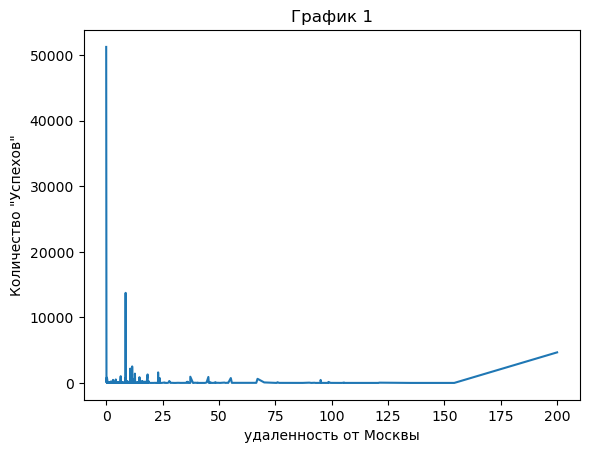

In [35]:
import matplotlib.pyplot as plt

df = pd.read_csv('data/ga_hits.csv')
df2 = pd.read_csv('data/ga_sessions.csv')
df3 = pd.merge(df, df2, on='session_id')


df3 = event_action(df3)
df3 = distance_from_moscow(df3)
df5 = df3[['event_action','distance_from_moscow']]

success = df5[df5['event_action'] == 1].value_counts()
no_success = df5[df5['event_action'] == 0].value_counts()

success = dict(success[1])
no_success = dict(no_success[0])


for entry in no_success.keys():
    if entry in success.keys():
        continue
    else:
        success[entry] = 0

success_sorted_list = sorted(success, reverse=True)

success_sorted = dict()
for entry in success_sorted_list:
    success_sorted[entry] = success[entry]
    
success_list = list(zip(success.keys(), success.values()))

with open('data/plot_1_data.txt', 'w') as file:
                
    for entry in success_list:
        line = f"{entry}\n"
        file.write(line)
        
x = success_sorted.keys()
y = success_sorted.values()

plt.plot(x,y)

plt.xlabel('удаленность от Москвы')
plt.ylabel('Количество "Успехов"')

plt.title('График 1')

plt.show()
    
    

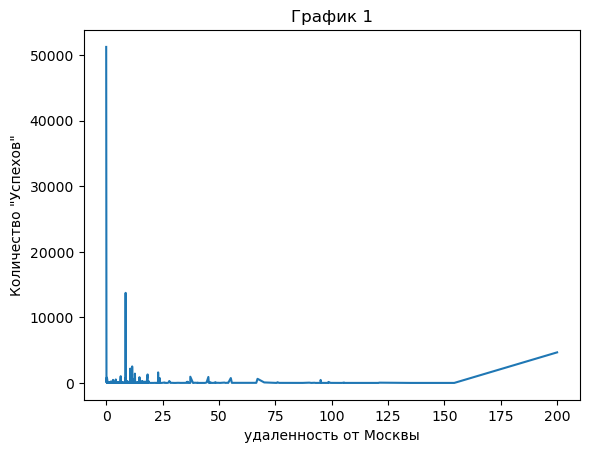

In [43]:
x = success_sorted.keys()
y = success_sorted.values()

plt.plot(x,y)

plt.xlabel('удаленность от Москвы')
plt.ylabel('Количество "Успехов"')

plt.title('График 1')

plt.show()
    

file was there


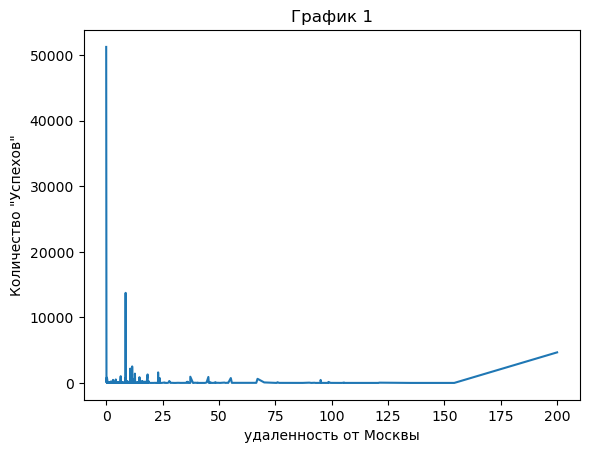

In [185]:
try:
    success_tst = dict()
    with open('data/plot_1_data.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            my_tuple = line.replace('(', '').replace(')', '').split(', ')
            success_tst[eval(my_tuple[0])] =  eval(my_tuple[1])       

    success_sorted_list = sorted(success_tst, reverse=True)

    success_sorted = dict()
    for entry in success_sorted_list:
        success_sorted[entry] = success_tst[entry]
        
except FileNotFoundError:
    
    df = pd.read_csv('data/ga_hits.csv')
    df2 = pd.read_csv('data/ga_sessions.csv')
    df5 = pd.merge(df, df2, on='session_id')
    df = None
    df2 = None


    df5 = event_action(df5)
    df5 = distance_from_moscow(df5)
    df5 = df5[['event_action','distance_from_moscow']]

    success = df5[df5['event_action'] == 1].value_counts()
    no_success = df5[df5['event_action'] == 0].value_counts()

    success = dict(success[1])
    no_success = dict(no_success[0])


    for entry in no_success.keys():
        if entry in success.keys():
            continue
        else:
            success[entry] = 0

    success_sorted_list = sorted(success, reverse=True)

    success_sorted = dict()
    for entry in success_sorted_list:
        success_sorted[entry] = success[entry]

    success_list = list(zip(success.keys(), success.values()))

    with open('data/plot_1_data.txt', 'w') as file:
        for entry in success_list:
            line = f"{entry}\n"
            file.write(line)
        
finally:    
    x = success_sorted.keys()
    y = success_sorted.values()

    plt.plot(x,y)

    plt.xlabel('удаленность от Москвы')
    plt.ylabel('Количество "Успехов"')

    plt.title('График 1')

    plt.show()


In [41]:
success_sorted == success_sorted2

True

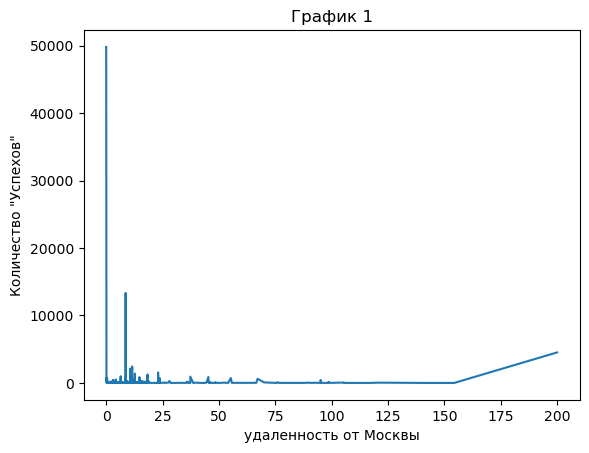

In [44]:
import matplotlib.pyplot as plt
import pandas as pd


try:
    success_tst = dict()
    with open('data/plot_1_data.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            my_tuple = line.replace('(', '').replace(')', '').split(', ')
            success_tst[eval(my_tuple[0])] = eval(my_tuple[1])

    success_sorted_list = sorted(success_tst, reverse=True)

    success_sorted = dict()
    for entry in success_sorted_list:
        success_sorted[entry] = success_tst[entry]

except FileNotFoundError:

    #df = pd.read_csv('data/ga_hits.csv')
    #df2 = pd.read_csv('data/ga_sessions.csv')
    df5 = pd.read_csv('data/df3_200k_50n_50p.csv') #merge(df, df2, on='session_id')
    df = None
    df2 = None

    #df5 = event_action(df5)
    df5 = distance_from_moscow(df5)
    df5 = df5[['event_action', 'distance_from_moscow']]

    success = df5[df5['event_action'] == 1].value_counts()
    no_success = df5[df5['event_action'] == 0].value_counts()

    success = dict(success[1])
    no_success = dict(no_success[0])

    for entry in no_success.keys():
        if entry in success.keys():
            continue
        else:
            success[entry] = 0

    success_sorted_list = sorted(success, reverse=True)

    success_sorted = dict()
    for entry in success_sorted_list:
        success_sorted[entry] = success[entry]

    success_list = list(zip(success.keys(), success.values()))

    with open('data/plot_1_data.txt', 'w') as file:
        for entry in success_list:
            line = f"{entry}\n"
            file.write(line)

finally:
    x = success_sorted.keys()
    y = success_sorted.values()

    plt.plot(x, y)

    plt.xlabel('удаленность от Москвы')
    plt.ylabel('Количество "Успехов"')

    plt.title('График 1')

    plt.show()


In [43]:
df5 = pd.read_csv('data/df3_200k_50n_50p.csv') #merge(df, df2, on='session_id')
df = None
df2 = None

#df5 = event_action(df5)
df5 = distance_from_moscow(df5)
df5 = df5[['event_action', 'distance_from_moscow']]

success = df5[df5['event_action'] == 1].value_counts()
no_success = df5[df5['event_action'] == 0].value_counts()

success = dict(success[1])
no_success = dict(no_success[0])

for entry in no_success.keys():
    if entry in success.keys():
        continue
    else:
        success[entry] = 0

success_sorted_list = sorted(success, reverse=True)

success_sorted = dict()
for entry in success_sorted_list:
    success_sorted[entry] = success[entry]

success_list = list(zip(success.keys(), success.values()))

with open('data/plot_1_data.txt', 'w') as file:
    for entry in success_list:
        line = f"{entry}\n"
        file.write(line)


file was there
